# Bayes Theorem
DA Probability & Statistics Learning Series • Lesson 3

<img src="https://imgs.xkcd.com/comics/frequentists_vs_bayesians_2x.png" align="center" height="600" width="300"/>

Welcome, again!

*See **#da_prob_stat** for discussion during and after this tutorial.*

## Goals
- Understand how to relate conditional probabilities to each other
- Define and apply the Law of Total Probability
- Incorporate new information to update your prior beliefs of an event
- Learn and practice Bayes Theorem in a complex setting

In [1]:
# Import dependencies 
import sys
from custom.db_utils import get_connection, get_data
import pandas as pd

# Object typing
from typing import TypeVar
PandasSeries = TypeVar('pd.core.series.Series')
PandasDataFrame = TypeVar('pd.core.frame.DataFrame')

# Data viz
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np

## Motivating Context 🤔

Between 1996-98, Sally Clark, a British woman, lost her two infant children under similarly mysterious circumstances. The defence argued that the children had died of *SIDS* - sudden infant death syndrome. However, the prosecution claimed that the probability of children from an affluent family, like Clark's, suffering from SIDS was 1 in 73 million. They used this to *prove* that she *must* be guilty of killing her children; in 1999, Clark was, in fact, convicted of murdering them.

**TODO:** How would you structure this as events?

> Sally Clark is guilty of killing her two children **because** it is *so* unlikely for them to have died mysteriously if she were innocent.

Sounds like a pretty reasonable statement right? It's inaccurate though!

**TODO:** What do you think makes this case funky?

The prosecution argued the following:

$$
\begin{split}
P(\text{innocence | evidence}) & = P(\text{evidence | innocence}) \\
P(\text{I | E}) & = P(\text{E | I})
\end{split}
$$

As we saw above, in plain English, that comparison sounds pretty normal. Mathematically though, it's really not.

From our lesson on conditional probability, we can infer:

$$
\begin{split}
P(I | E) & = \frac{P(I \cap E)}{P(E)} \\
\implies P(I \cap E) & = P(I | E)P(E)
\end{split}
$$

**and the other way too...**

$$
\begin{split}
P(E | I) & = \frac{P(I \cap E)}{P(I)} \\
\implies P(I \cap E) & = P(E | I)P(I)
\end{split}
$$

**thus**

$$
\begin{split}
P(I | E)P(E) & = P(E | I)P(I) \\ \\
\implies P(I | E) & = \frac{P(E | I)P(I)}{P(E)} \\ \\
\implies P(I | E) & \neq P(E | I)
\end{split}
$$

**CONCLUSIONS:**
- Equating a conditional to its inverse is incorrect.
-  When you are offered evidence, you don't want to throw out your prior belief entirely; you want to incorporate the new evidence to update your prior beliefs. Not doing so is the base rate fallacy.

The Sally Clark case was a statistical blunder. But the mistakes made by the prosecution in this case aren't exclusive to the courtroom.

A more trivial version of the [**Prosecutor's Fallacy**](https://towardsdatascience.com/the-prosecutors-fallacy-cb0da4e9c039) is saying:

>My partner hasn't texted me in 3 hours - they probably don't love me.

- $P(\text{doesn't love you | late text}) \neq P(\text{late text | doesn't love you})$
- The latter would understandably be very high, but the former is likely because they are either busy or are fed up of sheltering in place with you. Relax a little 😉

## Intro to Bayes

In [2]:
# Get the database connection and cursor objects
conn, cur = get_connection()

# Use a context manager to open and close connection and files
df = get_data('query.sql', 'file', conn)

# Preview the data
df.sample(3)

,shipment_id,accepted_quote_at,tradelane,mode
123367,710938,2020-01-14 00:00:00+00:00,TPEB,Ocean
191046,586799,2019-07-30 00:00:00+00:00,TAEB,Air
72982,798421,2020-05-27 00:00:00+00:00,TPEB,Ocean


In [3]:
# Isolate data to be used
tradelane_mode_df = df[['tradelane', 'mode']]
tradelane_mode_df

# Call Crosstab function from last time to get sums of tradelane and mode pairs.
tradelane_mode_xt = pd.crosstab(index=tradelane_mode_df['tradelane'], 
                               columns=tradelane_mode_df['mode'])

tradelane_mode_xt.head(3)

mode,Air,Ocean,Truck - Domestic,Truck - International
tradelane,,,,
Africa to North America,6,89,0,0
Domestic,75,325,5401,49
FEEB,227,242,0,0


## Classification with Conditional Probability ✈️🚢

Let's introduce this with an example (motivated from a lesson at UC Berkeley):

Let's say we know that: 
- 60% of shipments are Ocean and the remaining 40% are Air
- 50% of Ocean Shipments are on TPEB
- 80% of Air Shipments are on TPEB

Now suppose I pick a shipment at random. 

**TODO** Can you classify the shipment as Air or Ocean?

<b> You probably guessed ocean ... </b>

The shipment is picked at random and so you know that the chance that the shipment is Ocean is 60%. That's greater than the 40% chance of being an Air shipment, so you would classify the shipment as Ocean.

The information about the tradelane is irrelevant, as we already know the proportions of mode. 

We have a pretty simple classifier! 

But now suppose I give you some additional information about the shipment that was picked:

<b>The Shipment was on TPEB. </b>

**TODO:** Would this knowledge change your classification?

<b>Updating the Prediction Based on New Information </b>

Now that we know the shipment is on TPEB, it becomes important to look at the relation between shipment and mode.

In [4]:
mode = np.array(['Ocean']*60 + ['Air']*40)
tradelane = np.array(['Not TPEB']*30+['TPEB']*30+['Not TPEB']*8+['TPEB']*32)
df = {'Mode':mode,'Tradelane':tradelane}
df = pd.DataFrame(df, columns=['Mode','Tradelane'])

df.head()

,Mode,Tradelane
0,Ocean,Not TPEB
1,Ocean,Not TPEB
2,Ocean,Not TPEB
3,Ocean,Not TPEB
4,Ocean,Not TPEB


In [5]:
pd.crosstab(index=df['Tradelane'], columns=df['Mode'])

Mode,Air,Ocean
Tradelane,,
Not TPEB,8,30
TPEB,32,30


- The total count of shipments is 100 - 60 Ocean and 40 Air
- Since we know the shipment is on TPEB, though, our sample space is reduced to the 62 shipments in TPEB
- In TPEB, 32 of the 62 shipments are Air - that's over 50%!
- So, in the light of the new information about the tradelane, **we would update our prediction and classify the shipment as Air.**

The method that we have just used above is due to the Reverend [Thomas Bayes](https://en.wikipedia.org/wiki/Thomas_Bayes) (1701-1761). His method solved what was called an "inverse probability" problem: given new data, how can you update chances you had found earlier? Though Bayes lived three centuries ago, his method is widely used now in machine learning.

## Conditional Probability -> Bayes Theorem

Let's mathematically build up the intuition behind Bayes Theorem.

- Lets say Event A is Shipment is on Air. 
- Lets say Event B is Shipment being on TPEB. 

**From last time we know:**

The probability of two events A and B happening can be represented in two ways: 

$$
P(A \cap B) = P(A)P(B \mid A) = P(B)P(A \mid B)
$$

That is, we now have:

$$
P(B)P(A \mid B) = P(A)P(B \mid A)
$$

And that's actually it. Moving $P(B)$ to the other side, we have Bayes Theorem for the two event case:

$$
P(A \mid B) = \frac{P(A) P(B \mid A)} {P(B)}
$$

This formula is useful, but we might not always know $P(B)$. The Law of Total Probability gives us a way to compute it.

## The Law of Total Probability 📜

Now we need connect conditional and unconditional probabilities. We do this with **the Law of Total Probability** (LOTP). 


You'll also have the tools to deal with conditioning on multiple events/pieces of information since the concepts translate generally.



**The Law of Total Probability** is an incredibly useful problem solving tool. Formally stated, it says:

$$
\text{If }A_i,...,A_n \text{ is a partition of the sample space }S \text{, then } \\ \\
P(B) = \sum_{i=1}^{n}{P(B|A_i)P(A_i)}
$$

But this is likely better illustrated with a picture:

<img src="./LOTP.png" width="600" height="400"/>

Okay, your turn to practice!

**Question**: 

> What's $P(\text{TPEB})$. 

Partition the data and use LOTP so you can calculate it. Check against the data directly.

In [6]:
## TODO: Demonstrate LOTP on our data; start with tradelane_mode_xt
tradelane_mode_xt

mode,Air,Ocean,Truck - Domestic,Truck - International
tradelane,,,,
Africa to North America,6,89,0,0
Domestic,75,325,5401,49
FEEB,227,242,0,0
FEWB,6560,22266,6,36
Latin NB,567,932,901,243
NA Export,134,2934,0,8
Oceania NB,49,76,0,0
ROW,2155,3957,582,806
TAEB,1561,4205,1,0


In [7]:
# This is the denominator to convert cardinality of sets to probabilities
# (per the Naive Definition of Probability)
S = tradelane_mode_xt.sum().sum()

# Show that p_TPEB_by_LTOP == p_TPEB
p_TPEB = tradelane_mode_xt.loc['TPEB',:].sum()/S

p_Air = tradelane_mode_xt.loc[:,'Air'].sum()/S

p_not_Air = 1 - p_Air

p_TPEB_given_Air = tradelane_mode_xt.loc['TPEB', 'Air'] / tradelane_mode_xt.loc[:,'Air'].sum()

p_TPEB_given_not_Air = tradelane_mode_xt.drop(columns='Air').loc['TPEB',:].sum()\
                        / tradelane_mode_xt.drop(columns='Air').loc[:,:].sum().sum()

p_TPEB_by_LOTP = p_TPEB_given_Air * p_Air + p_TPEB_given_not_Air * p_not_Air

# Check if our answer is right   
print(f"Our Answer: {p_TPEB_by_LOTP:.5%}")
print(f"Expected Answer: {p_TPEB:.5%}")

Our Answer: 66.07772%
Expected Answer: 66.07772%


### Definition Glossary

$$
P(A \mid B) = \frac{P(A) P(B \mid A)} {P(B)}
$$

- **Marginal Probability**: Unconditional probability of an event. eg. $P(A)$ and $P(B)$
- **Prior Probability**: A type of marginal probability relevant to Bayes Theorem. It is the probability of an event based on our prior beliefs about that event. Here, $P(A)$ is the prior. The posterior is the updated probability of the prior given new information from event $B$.
- **Posterior Probability**: The conditional probability we are trying to compute - $P(A \mid B)$
- **Likelihood**: This is the inverse of the conditional probablity we are trying to compute. If we are interested in $P(A \mid B)$, likelihood refers to $P(B \mid A)$

## Updating Priors ☝🏽

Bayes Theorem, and conditional probability in general, can be framed in multiple ways:
- $P(A|B)$ = Probability that event $A$ occurs *given* that event $B$ has occured
- $P(A|E)$ = Probability of hypothesis $A$ being true *given* certain evidence $E$
- $P(A|B)$ = Updated probability of event $A$ occurring *given* additional information from event $B$

In each of these s scenarios, we:
1. take an event $A$ that has some probabilty of ocurrring in isolation - $P(A)$
2. we update that probability $P(A)$ by incorporating information from event $B$ ocurring: that gives us $P(A|B)$

We've seen that Bayes Theorem helps us relate conditional probabilities to one another. Now let's look at how it can be leveraged to update our prior beliefs about certain events.

### Ravi Goes to Disneyland 🏰

Ravi is excited that Disneyland has finally opened up and he has taken the day off to go to LA and enjoy Goofy's Sky School after months of waiting. However, for him to be able to enter Disneyland, the management needs to be certain that he doesn't have COVID-19; he's got to get tested.

Nervous about his fate, Ravi goes to the Disneyland clinic and waits for the doctor. When the doctor arrives, she makes an initial assessment of him. She comments that since Ravi looks asymptomatic and generally quite energized, he probably does not have COVID. However, since he took a flight to LA, it's quite possible that he might have contracted the virus while not social distancing on board. She thinks for a few minutes, notes down some stuff, and concludes that Ravi's prior (*pre-test*) probability of having COVID is:

$$
P(D) = 0.3 = 30\%
$$

She then prepares to test him.

The doctor's test, **Test 1**, is 90% accurate. If someone has COVID, the test correctly returns 'positive' 90% of the time; if they don't have COVID, the test correctly returns 'negative' 90% of the time. 

Said another way, both the false positive and false negative rates are 10% respectively. (Later we'll talk about _sensitivity_ and _specificity_.)

Ravi is administered the test and his results come out **negative**! Let $T_1$ be the event that Ravi tests positive with **Test 1**; $T_1^c$ is the event that he tests negative. Then,

$$
\begin{split}
P(D \mid T_1^c) & & & = \frac{P(T_1^c \mid D)P(D)}{P(T_1^c)} \\ \\
& & & = \frac{P(T_1^c \mid D)P(D)}{P(T_1^c \mid D)P(D) + P(T_1^c \mid D^c)P(D^c)} \\ \\
& & & = \frac{(0.1)(0.3)}{(0.1)(0.3) + (0.9)(0.7)} \\ \\
& & & = 0.045 = 4.5\%
\end{split}
$$

The posterior probability of Ravi having COVID (remember, that's $P(D|T_1^c$) is 4.5% — a significant decrease from the prior probability of 30% that the doctor assumed when Ravi came in. 

In this way, we've 'updated our priors' using the information that the first test came back negative!

**Note:** We didn't entirely discard the original assessment of 30% that Ravi has COVID. Instead, we simply updated that assessment using the results of a test.

Unfortunately, even a test with 90% accuracy can't confirm that Ravi does not have COVID. A 4.5% chance is above the **strict threshold of 2%** that Disney is enforcing on its visitors and Ravi doesn't meet that cut. Sorry bud ☹️

**TODO:**
- What if the doctor felt differently during her initial evaluation of Ravi's health? 
- Or what if Ravi was both corrupt and desperate and offered the doctor $1000 for a 'better' initial evaluation?

Would that alter the posterior probability?

Try for yourself!

In [8]:
import matplotlib.pyplot as plt

Question 1
---


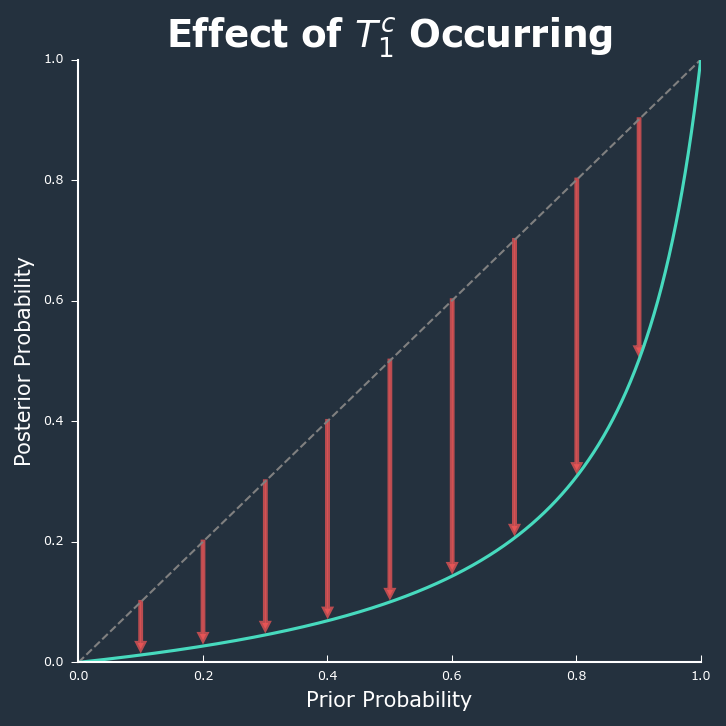

In [9]:
## TODO
# Loop through a few values of using the compute_bayes_posterior function to see for yourself!

# calculate P(A|B) when provided P(A), P(B|A), P(B|not A)
def compute_posterior(p_a, p_b_given_a, p_b_given_not_a):
    # calculate P(not A)
    not_a = 1 - p_a
    # calculate P(B)
    p_b = p_b_given_a * p_a + p_b_given_not_a * not_a
    # calculate P(A|B)
    p_a_given_b = (p_b_given_a * p_a) / p_b
    return p_a_given_b

# P(T1_c | D) = P(Tests Negative GIVEN Has COVID)
p_T1_c_given_D = 0.1

# P(T1_c | not D) = P(Tests Negative GIVEN Does Not Have COVID)
p_T1_c_given_not_D = 0.9

print('Question 1\n---')
# Calculate P(D | T1_c) for various values of P(D)

# Generate data
x = np.linspace(0, 1, 1000)
y = [compute_posterior(D, p_T1_c_given_D, p_T1_c_given_not_D) for D in x] 
df = pd.DataFrame(zip(x, y), columns=['Prior', 'Posterior'])

# Plot
plt.style.use('Python_2/flxtdark.mplstyle')
fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.patch.set_facecolor('#24313e')
ax.plot(df['Prior'], df['Prior'], ls='--', lw=1, c='grey')
ax.plot(df['Prior'], df['Posterior'])
ax.set_ylabel("Posterior Probability", fontsize=10)
ax.tick_params(axis='y', direction='out',
               grid_alpha = 1, grid_color = 'white')
ax.set_ylim(0,1)
ax.set_xlabel("Prior Probability", fontsize=10)
ax.set_xlim(0,1)
ax.tick_params(axis = 'both', which = 'major', labelsize = 6)

for x in range(100, 1000, 100):
    arr = plt.arrow(df.loc[x, 'Prior'], df.loc[x, 'Prior'],
                    0, df.loc[x, 'Posterior'] - df.loc[x, 'Prior'] + 0.02, 
                    color='#fb5858', head_width=0.01, head_length=0.01, 
                    lw=2, capstyle='projecting', alpha=0.7)
    
plt.title('Effect of $T_1^c$ Occurring')
plt.tight_layout()
plt.show()

In [10]:
print('\nQuestion 2\n---')
# Use a while loop to figure out the first value of P(c) for which P(C|Nx) is less than 1%
pD = 0.3
while pD > 0:
    p_D_given_T1_c = compute_posterior(pD, p_T1_c_given_D, p_T1_c_given_not_D)
    if p_D_given_T1_c < 0.02:
        print(f'Had the doctor\'s initial assessment been P(D) = {pD:.0%} or less, P(D | T1_c) would have been less than 2%')
        break
    pD -= 0.01
else:
    print('Given the effectiveness of the test, there is no prior probability of COVID that can bring the posterior probability less than 2%')


Question 2
---
Had the doctor's initial assessment been P(D) = 15% or less, P(D | T1_c) would have been less than 2%


## Multiple Conditions

Fortunately, bribing the doc isn't necessarily Ravi's only solution to entering Disneyland.

The doctor says she has a second test, **Test 2** that is **conditionally independent** of the results of **Test 1** given that the patient has/doesn't have COVID. It's also not as good as **Test 1** with an accuracy of just 70%.

**TODO:** What is the doctor's latest assessment of Ravi's likelihood of having COVID? Is it different from her initial assessment?

**TODO:** Given that we know Ravi tested negative on **Test 1**, is the second test more or less likely to be negative? What can we say about $P(T_2^c \mid T_1^c)$?

Ravi tests negative on **Test 2**, but we still don't know for sure if he has the virus or not. We need to update our prior beliefs once again and this time, we need to compute:

$$
P(D \mid T_1^c, T_2^c)
$$

Well, how?.. Let's learn a new concept to help us out.

## Conditional Independence

Events refresher:

$D$ = Event that Ravi has COVID
<br>
$T_1$ = Event that Ravi tests positive in **Test 1**
<br>
$T_1^c$ = Event that Ravi tests negative in **Test 1**
<br>
$T_2$ = Event that Ravi tests positive in **Test 2**
<br>
$T_2^c $= Event that Ravi tests negative in **Test 2**

If Ravi tests negative on **Test 1**, that reveals something about him as a person. After the test, Ravi isn't a random person we've picked off the street anymore, and we have some additional info about him going into **Test 2**. Thus,

$$
P(T_2^c \mid T_1^c) \neq P(T_2^c)
$$

Events $T_1^c$ and $T_2^c$ are **not independent**. Let's visualize this.

Our entire event space is paritioned by the event of testing either positive or negative with **Test 1**

<img src="conditional_independence_t1_partition.jpg" width="500" height="400"/>

The events associated with **Test 2** also partition our event space.

<img src="conditional_independence_t1_t2.png" width="500" height="400"/>

Without doing the math behind this and just going off our intuition so far, the dependence of events $T_1^c$ and $T_2^c$ is represented by $P(T_2^c \mid T_1^c)$ being greater than $P(T_2^c \mid T_1)$. 

We get these probabilities by **zooming** into the areas that we are conditioning on.

$P(• \mid T_1^c)$

Given Ravi tests negative on **Test 1**, the probability that he tests negative on **Test 2** is **larger** than the probability that he tests positive on it.

<img src="conditional_independence_t1_c.jpg" width="500" height="400"/>

$P(• \mid T_1)$

If Ravi were to test positive on **Test 1**, the probability that he will test negative on **Test 2** will be **smaller** than the probability that he will test positive on it.

<img src="conditional_independence_t1.jpg" width="500" height="400"/>

Now, let's introduce the event of Ravi having COVID. Not testing positive or negative for it, but *actually having it*

<img src="conditional_independence_all.jpg" width="500" height="400"/>

As stated earlier, after the negative results on both **Test 1** and **Test 2**, we want to know $P(D \mid T_1^c, T_2^c)$. Diagrammatically, this is the <span style="color:red; font-weight:800">red</span> area divided by the <span style="color:green; font-weight:800">green</span> area:

<img src="conditional_independence_d_given_t1_c_t2_c.png" width="500" height="400"/>

Mathematically, that proportion is:

$$
\begin{split}
P(D \mid T_1^c, T_2^c) = & \frac{P(D \cap T_1^c \cap T_2^c)}{P(T_1^c \cap T_2^c)} \\ \\
= & \frac{P(T_1^c \cap T_2^c \cap D)}{P(T_1^c \cap T_2^c)} \\ \\
= & \frac{P(T_1^c \cap T_2^c \mid D) P(D)}{P(T_1^c \cap T_2^c)} \\ \\
= & \frac{P(T_1^c, T_2^c \mid D) P(D)}{P(T_1^c, T_2^c)}
\end{split}
$$

Both the drawing and the math *seem* hard to compute. But, since $T_1^c$ and $T_2^c$ are **conditionally independent** give event $D$, we can simplify the following from the numerator:

$$
P(T_1^c, T_2^c \mid D) = P(T_1^c \mid D)P(T_2^c \mid D)
$$

Conditional independence says that, given that $D$ occurs (Ravi has COVID), $T_1^c$ and $T_2^c$ are independent. That is, if we know whether or not Ravi has COVID, the results of Test 2 aren't "influenced" by Test 1 (vice versa).

Note that this is NOT the saying that Test 2 isn't "influenced" by Test 1 if we didn't know whether Ravi had COVID or not — to make this statement (i.e., that Test 1 and T2 are \[unconditionally\] independent) would be incorrect.

Visually it says that, given $D$ occurs (we zoom into $D$), $T_1^c$ and $T_2^c$ are independent. That is, given $D$, $P(T_2^c \mid T_1^c) = P(T_2^c)$

<img src="conditional_independence_t2_c_given_d.png" width="500" height="400"/>

The ratio $X:Y$ from above is maintained even when we *zoom into* both $D$ and $T_1^c$

<img src="conditional_independence_given_d.png" width="500" height="400"/>

So, tying a few things together:

$$
P(D \mid T_1^c, T_2^c) = 
    \frac{P(T_1^c, T_2^c \mid D) P(D)}{P(T_1^c, T_2^c)} =
    \frac{P(T_1^c \mid D)P(T_2^c \mid D) P(D)}{P(T_1^c, T_2^c)}
$$

We know all the values in the numerator and you can see how to use LOTP on the denominator in the appendix. But long story short, negative results on both **Test 1** and **Test 2** bring down the probability that Ravi has COVID to less than 2% and he **is able to go to Disneyland** 🙃

### Appendix

**The challenge of $P(C \mid N_X \cap N_Y)$**

$P(C \mid N_X \cap N_Y)$ relies on computing $P(N_X \mid N_Y)$ or $P(N_Y \mid N_X)$. Those are kind of tricky. Using LOTP, here's what they expand into:

$$
P(N_Y \mid N_X) = P(N_Y \mid C \cap N_X)P(C \mid N_X) + P(N_Y \mid C^c \cap N_X)P(C^c \mid N_X)
$$

Try to draw out the set to explain to yourself why that expansion makes sense!